### Generation of summary performance characteristics for each metabolism model
- Created by: Louis Groff
- PIs: Imran Shah and Grace Patlewicz
- Last modified: 04 March 2024
- Changes made: Re-run notebook to verify functionality for journal revisions and create new ROC curve

In [1]:
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
TOP = os.getcwd().replace("notebooks", "")
raw_dir = TOP + 'data/raw/'
processed_dir = TOP + 'data/processed/'
figures_dir = TOP + 'reports/figures/'
jcim = TOP + 'data/raw/JCIM_PhaseI/'
smpdb = TOP + 'data/raw/smpdb_drugs/'
missing = TOP + 'data/raw/extra_metsim/'

In [3]:
def flat_list(in_l):
    """
    flatten a nested list into a single list via NumPy append functions.
    """
    import numpy as np
    if in_l == []:
        return in_l
    if isinstance(in_l[0], list):
        return np.append(flat_list(in_l[0]), flat_list(in_l[1:]))
    return np.append(in_l[:1], flat_list(in_l[1:]))

def mtb_gen_pred(pred_mtb_list = None, pred_idx = None, pred_dict = None):
    """
    list metabolites within the prediction set
    pred_mtb_list: list of predicted metabolites from parent compound
    pred_dict: prediction dataset, list of dictionaries
    pred_idx: Index of pred_dict for which generation n successors contain at least one precursor for generation n+1
    returns the full list of predicted metabolite SMILES across all generations of precursors/successors.
    """
    # print('current pred index = '+str(pred_idx)) #used for diagnosing matching issues
    try:
        pred_mtb_list = np.append(pred_mtb_list,[[pred_dict[pred_idx]['output'][i]['successors'][j]['metabolite']['inchikey'] for j in range(len(pred_dict[pred_idx]['output'][i]['successors'])) if pred_dict[pred_idx]['output'][i]['successors'][j]['metabolite']['inchikey'] != None] for i in range(len(pred_dict[pred_idx]['output']))])
        pred_mtb_list = flat_list(in_l = list(pred_mtb_list))
        pred_mtb_list = pred_mtb_list[pred_mtb_list != np.array(None)]
        pred_mtb_list = np.unique(pred_mtb_list)
    except:
        pred_mtb_list = []
    return pred_mtb_list

def mtb_gen_valid(valid_mtb_list = None, valid_idx = None, valid_dict = None):
    """
    recursive search for observed metabolites within the validation set
    pred_mtb_list: list of predicted metabolites from parent compound
    valid_mtb_list: list of observed metabolites from parent compound
    valid_dict: validation dataset, list of dictionaries
    valid_idx: Index of valid_dict for which generation n successors contain at least one precursor for generation n+1
    returns the full list of observed metabolite SMILES across all generations of precursors/successors.
    """
    # print('current valid index = '+str(valid_idx)) #used for diagnosing matching issues
    if valid_idx != []:
        valid_precursors = flat_list([[valid_dict[i]['output'][j]['precursor']['inchikey'] for j in range(len(valid_dict[i]['output'])) if valid_dict[i]['output'][j]['precursor']['inchikey'] != None] for i in range(len(valid_dict))])
        valid_mtb_list = np.append(valid_mtb_list, [[[valid_dict[valid_idx[j]]['output'][k]['successors'][i]['metabolite']['inchikey'] for i in range(len(valid_dict[valid_idx[j]]['output'][k]['successors'])) if valid_dict[valid_idx[j]]['output'][k]['successors'][i]['metabolite']['inchikey'] != None] for k in range(len(valid_dict[valid_idx[j]]['output'])) ]for j in range(len(valid_idx))])
        valid_mtb_list = [x for x in valid_mtb_list if x != None and x != []]
        valid_mtb_list = flat_list(valid_mtb_list)
        valid_mtb_list = np.unique(valid_mtb_list)
        # if len(valid_mtb_list) > 0:
        #     tmp_idx = list(compress(range(len(valid_precursors)), [valid_precursors[i] in valid_mtb_list for i in range(len(valid_precursors))]))
        #     if tmp_idx != [] and tmp_idx != valid_idx:
        #         return mtb_gen_valid(valid_mtb_list = valid_mtb_list, valid_idx = tmp_idx, valid_dict = valid_dict)
    else:
        valid_mtb_list = []
    return np.array(valid_mtb_list)

In [4]:
def metsim_performance(in_df = None, pred_dict = None, valid_dict = None, tool = None):
    """
    """
    if pred_dict != None:
        if valid_dict != None:
            if type(in_df) != type(None):
                if len(in_df) == 0:
                    in_df['parent_name'] = [valid_dict[i]['input']['chem_name'] for i in range(len(pred_dict))]
                    in_df['parent_inchi'] = [valid_dict[i]['input']['inchikey'] for i in range(len(pred_dict))]
                out_list = []
                #sort pred_dict to match data sorting of valid dict in case it is sorted differently:
                pred_dict = [[pred_dict[i] for i in range(len(pred_dict)) if pred_dict[i]['input']['chem_name'] == in_df.loc[j,'parent_name']][0] for j in range(len(in_df))]
                for pred_idx in range(len(pred_dict)):
                    mtb_list = mtb_gen_pred(pred_idx = pred_idx, pred_dict = pred_dict)
                    dict_idx = [i for i in range(len(valid_dict)) if pred_dict[pred_idx]['input']['inchikey'].split('-')[0] == valid_dict[i]['input']['inchikey'].split('-')[0] and valid_dict[i]['input']['inchikey'] != None]
                    valid_mtb_list = mtb_gen_valid(valid_idx = dict_idx, valid_dict = valid_dict)
                    out_list.append([mtb_list,valid_mtb_list, pred_dict[pred_idx]['input']['chem_name']])
                pred_inchi = [[out_list[i][0][j] for j in range(len(out_list[i][0])) if len(out_list[i][0]) > 0] for i in range(len(out_list))]
                valid_inchi = [[out_list[i][1][j] for j in range(len(out_list[i][1])) if len(out_list[i][1]) > 0 and out_list[i][1][j] != None] for i in range(len(out_list))]
                pred_inchi_2d = [[out_list[i][0][j].split('-')[0] for j in range(len(out_list[i][0])) if len(out_list[i][0]) > 0 and type(out_list[i][0][j]) != dict] for i in range(len(out_list))]
                valid_inchi_2d = [np.unique([out_list[i][1][j].split('-')[0] for j in range(len(out_list[i][1])) if len(out_list[i][1]) > 0 and out_list[i][1][j] != None]) for i in range(len(out_list))]
                match_inchi = [[pred_inchi[i][j] for j in range(len(pred_inchi[i])) if len(pred_inchi_2d[i]) > 0  and pred_inchi_2d[i][j] in valid_inchi_2d[i]] for i in range(len(pred_inchi))]
                match_inchi_2d = [np.unique([match_inchi[i][j].split('-')[0] for j in range(len(match_inchi[i]))]) for i in range(len(match_inchi))]
                missed_inchi = [[valid_inchi[i][j] for j in range(len(valid_inchi[i])) if valid_inchi_2d[i][j] not in match_inchi_2d[i]] for i in range(len(valid_inchi))]
                # for i in range(len(pred_dict)):
                #     print('idx:',i,'\npreds:',len(pred_inchi[i]),'\nvalid:',len(valid_inchi[i]),'\nmatch:',len(match_inchi[i]),len(match_inchi_2d[i]),'\n')
                if tool != None:
                    in_df[str(tool)+'_n_preds'] = [len(pred_inchi_2d[i]) for i in range(len(pred_inchi_2d))]
                    in_df['n_metabolites'] = [len(valid_inchi_2d[i]) for i in range(len(valid_inchi_2d))]
                    in_df[str(tool)+'_n_tp'] = [len(match_inchi_2d[i]) for i in range(len(match_inchi_2d))]
                    in_df[str(tool)+'_tpr'] = [len(match_inchi_2d[i])/len(valid_inchi_2d[i]) if len(valid_inchi_2d[i]) != 0 else 0 for i in range(len(match_inchi_2d))]
                    in_df[str(tool)+'_n_fn'] = [len(missed_inchi[i]) for i in range(len(missed_inchi))]
                    print('==========================================\nSummary Performance for Tool/Model: '+str(tool))
                    print('==========================================')
                    print('True Positives: ',sum(in_df[str(tool)+'_n_tp']))
                    print('False Positives: ',sum(in_df[str(tool)+'_n_preds'])-sum(in_df[str(tool)+'_n_tp']))
                    print('False Negatives: ',sum(in_df[str(tool)+'_n_fn']))
                    print('Total No. of Predictions: ',sum(in_df[str(tool)+'_n_preds']))
                    print('Precision: ',round(sum(in_df[str(tool)+'_n_tp'])/sum(in_df[str(tool)+'_n_preds']),3))
                    print('Recall: ',round(sum(in_df[str(tool)+'_n_tp'])/sum(in_df['n_metabolites']),3))
                    print('Total No. Reported Metabolites:',sum(in_df['n_metabolites']))
                    print('==========================================')
                    return in_df
                
                else:
                    raise('"tool" == None. Please provide an abbreviated string format name for the MetSim tool.')
            else:
                raise('"in_df" is not at dataframe. Please include valid output dataframe.')
        else:
            raise('"valid_dict" == None. Please include list of validated metabolites.')
    else:
        raise('"pred_dict" == None. Please include list of predicted metabolites.')

    return None


Create a dictionary of the tools and prediction model outcomes as key/value pairs. Pass into the metsimperformance function to create a summary performance dataframe from which Figure 4 heatmap can be 

In [5]:
tools = ['cts', 'btrans', 'tb_s9','tb_vivo', 'times_s9', 'times_vivo', 'aggregate']

In [6]:
pred_cts = json.load(open(processed_dir+'cts_metsim_smpdb_jcim_112parents.json','r'))

In [7]:
tool_dict = [ 'cts_metsim_smpdb_jcim_112parents.json',
              'btrans_metsim_smpdb_jcim_112parents.json',
             'tb_metsim_ratlivers9_smpdb_jcim_112parents.json',
              'tb_metsim_invivoratsimulator_smpdb_jcim_112parents.json',
             'times_metsim_ratlivers9_smpdb_jcim_112parents.json',
'times_metsim_invivoratsimulator_smpdb_jcim_112parents.json',
 'metsim_aggregate_smpdb_jcim_112parents.json'
]

In [8]:
tool_dict = {k:v for k,v in zip(tools, tool_dict)}

In [9]:
tool_dict2 = {k: json.load(open(processed_dir+v, 'r')) for k,v in tool_dict.items()}

In [10]:
valid_dict = json.load(open(processed_dir+'smpdb_jcim_valid_aggregate_112parents.json','r'))

In [11]:
if 'tpr_df' not in locals():
    tpr_df = pd.DataFrame(columns = ['parent_name', 'parent_inchi', 'chem_class', 'n_metabolites'])
    for k,v in tool_dict2.items():
        tpr_df = metsim_performance(tool=k, pred_dict = v, valid_dict = valid_dict, in_df = tpr_df)
        

/home/grace/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1859: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)
/tmp/ipykernel_2233504/4087298185.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  missed_inchi = [[valid_inchi[i][j] for j in range(len(valid_inchi[i])) if valid_inchi_2d[i][j] not in match_inchi_2d[i]] for i in range(len(valid_inchi))]
/home/grace/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1859: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If

Summary Performance for Tool/Model: cts
True Positives:  234
False Positives:  13230
False Negatives:  198
Total No. of Predictions:  13464
Precision:  0.017
Recall:  0.542
Total No. Reported Metabolites: 432


/tmp/ipykernel_2233504/4087298185.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  missed_inchi = [[valid_inchi[i][j] for j in range(len(valid_inchi[i])) if valid_inchi_2d[i][j] not in match_inchi_2d[i]] for i in range(len(valid_inchi))]
/home/grace/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1859: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


Summary Performance for Tool/Model: btrans
True Positives:  216
False Positives:  27296
False Negatives:  216
Total No. of Predictions:  27512
Precision:  0.008
Recall:  0.5
Total No. Reported Metabolites: 432


/tmp/ipykernel_2233504/4087298185.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  missed_inchi = [[valid_inchi[i][j] for j in range(len(valid_inchi[i])) if valid_inchi_2d[i][j] not in match_inchi_2d[i]] for i in range(len(valid_inchi))]
/home/grace/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1859: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


Summary Performance for Tool/Model: tb_s9
True Positives:  173
False Positives:  1030
False Negatives:  259
Total No. of Predictions:  1203
Precision:  0.144
Recall:  0.4
Total No. Reported Metabolites: 432


/tmp/ipykernel_2233504/4087298185.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  missed_inchi = [[valid_inchi[i][j] for j in range(len(valid_inchi[i])) if valid_inchi_2d[i][j] not in match_inchi_2d[i]] for i in range(len(valid_inchi))]
/home/grace/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1859: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


Summary Performance for Tool/Model: tb_vivo
True Positives:  173
False Positives:  1289
False Negatives:  259
Total No. of Predictions:  1462
Precision:  0.118
Recall:  0.4
Total No. Reported Metabolites: 432


/tmp/ipykernel_2233504/4087298185.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  missed_inchi = [[valid_inchi[i][j] for j in range(len(valid_inchi[i])) if valid_inchi_2d[i][j] not in match_inchi_2d[i]] for i in range(len(valid_inchi))]
/home/grace/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1859: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


Summary Performance for Tool/Model: times_s9
True Positives:  170
False Positives:  1162
False Negatives:  262
Total No. of Predictions:  1332
Precision:  0.128
Recall:  0.394
Total No. Reported Metabolites: 432


/tmp/ipykernel_2233504/4087298185.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  missed_inchi = [[valid_inchi[i][j] for j in range(len(valid_inchi[i])) if valid_inchi_2d[i][j] not in match_inchi_2d[i]] for i in range(len(valid_inchi))]
/home/grace/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1859: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


Summary Performance for Tool/Model: times_vivo
True Positives:  172
False Positives:  1120
False Negatives:  260
Total No. of Predictions:  1292
Precision:  0.133
Recall:  0.398
Total No. Reported Metabolites: 432
Summary Performance for Tool/Model: aggregate
True Positives:  313
False Positives:  38303
False Negatives:  119
Total No. of Predictions:  38616
Precision:  0.008
Recall:  0.725
Total No. Reported Metabolites: 432


/tmp/ipykernel_2233504/4087298185.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  missed_inchi = [[valid_inchi[i][j] for j in range(len(valid_inchi[i])) if valid_inchi_2d[i][j] not in match_inchi_2d[i]] for i in range(len(valid_inchi))]


In [12]:
tpr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   parent_name         112 non-null    object 
 1   parent_inchi        112 non-null    object 
 2   chem_class          0 non-null      object 
 3   n_metabolites       112 non-null    int64  
 4   cts_n_preds         112 non-null    int64  
 5   cts_n_tp            112 non-null    int64  
 6   cts_tpr             112 non-null    float64
 7   cts_n_fn            112 non-null    int64  
 8   btrans_n_preds      112 non-null    int64  
 9   btrans_n_tp         112 non-null    int64  
 10  btrans_tpr          112 non-null    float64
 11  btrans_n_fn         112 non-null    int64  
 12  tb_s9_n_preds       112 non-null    int64  
 13  tb_s9_n_tp          112 non-null    int64  
 14  tb_s9_tpr           112 non-null    float64
 15  tb_s9_n_fn          112 non-null    int64  
 16  tb_vivo_

In [91]:
len(smpdb_fnams)

40

In [108]:
len(clyf_fnams)

98

In [107]:
len(clyf_tuples)

98

In [13]:
#ClassyFire data processing:

#store lists of filenames from ClassyFire results for SMPDB Dataset and JCIM dataset respectively:
smpdb_fnams = os.listdir(smpdb)

smpdb_fnams = [smpdb+smpdb_fnams[i] for i in range(len(smpdb_fnams))]
jcim_fnams = os.listdir(jcim)

jcim_fnams = [jcim+jcim_fnams[i] for i in range(len(jcim_fnams))]

extras_fnams = os.listdir(missing)
extras_fnams = [missing+extras_fnams[i] for i in range(len(extras_fnams))]
#append the two lists into one
clyf_fnams = jcim_fnams+smpdb_fnams+extras_fnams
clyf_fnams  = [e for e in clyf_fnams if 'json' in e]
#store list of ClassyFire class data for all available files:
clyf_classes = [json.load(open(clyf_fnams[i],'r')) for i in range(len(clyf_fnams))]

#Tuple together the ClassyFire data with its respective inchikey from the performance dataframe (tpr_df)
clyf_tuples = [(clyf_classes[i]['inchikey'].split('=')[1], clyf_classes[i]['class']['name']) if clyf_classes[i]['inchikey'].split('=')[1].split('-')[0] in [tpr_df.loc[k,'parent_inchi'].split('-')[0] for k in range(len(tpr_df['parent_inchi']))] else None for i in range(len(clyf_classes))]
# print(clyf_tuples) #To inspect tuple data for cross-checks

#For each parent chemical, if ClassyFire data exists, store its chemical class, else store "No ClassyFire Data"
for i in range(len(tpr_df)):
    #match on inchikey first block
    if tpr_df.loc[i,'parent_inchi'].split('-')[0] in [clyf_tuples[k][0].split('-')[0] for k in range(len(clyf_tuples))]:
        for j in range(len(clyf_tuples)):
            if tpr_df.loc[i,'parent_inchi'].split('-')[0] == clyf_tuples[j][0].split('-')[0]:
                tpr_df.loc[i,'chem_class'] = clyf_tuples[j][1]
    else:
        #no match found in available class data.
        tpr_df.loc[i,'chem_class'] = 'No ClassyFire Data'

In [16]:
tpr_df.chem_class.unique()

array(['Diazinanes', 'Pyrroles', 'Phenanthrenes and derivatives',
       'Azoles', 'Carboxylic acids and derivatives', 'Piperidines',
       'Naphthalenes', 'Benzoxazines',
       'Nucleoside and nucleotide analogues',
       'Benzene and substituted derivatives', 'Benzimidazoles', 'Lactams',
       'Steroids and steroid derivatives', 'Quinolines and derivatives',
       'Organonitrogen compounds', 'Linear 1,3-diarylpropanoids',
       'Benzodiazepines', 'Phenol ethers', 'Benzothiazepines', 'Diazines',
       'Triazines', 'Indoles and derivatives', 'Organooxygen compounds',
       'Phenylpropanoic acids', 'Phenols', 'Benzothiazines', 'Pyrrolines',
       'Indenes and isoindenes', 'Imidazopyrimidines', 'Prenol lipids',
       'Thioethers', "5'-deoxyribonucleosides", 'Benzazepines',
       'Morphinans', 'Benzoxepines', 'Anthracyclines', 'Lignan lactones',
       'Oxazaphosphinanes', 'Camptothecins', 'Isocoumarans',
       'Pyridines and derivatives', 'Stilbenes', 'Fatty Acyls'],
      dt

In [17]:
tpr_df.to_csv(processed_dir+'summary_performance_290224.csv')

In [18]:
tpr_df[tpr_df['parent_name'] == 'Adefovir Dipivoxil']

,parent_name,parent_inchi,chem_class,n_metabolites,cts_n_preds,cts_n_tp,cts_tpr,cts_n_fn,btrans_n_preds,btrans_n_tp,...,times_s9_tpr,times_s9_n_fn,times_vivo_n_preds,times_vivo_n_tp,times_vivo_tpr,times_vivo_n_fn,aggregate_n_preds,aggregate_n_tp,aggregate_tpr,aggregate_n_fn
59,Adefovir Dipivoxil,WOZSCQDILHKSGG-QVUQFMIFNA-N,Imidazopyrimidines,3,19,0,0.0,3,47,0,...,0.0,3,15,0,0.0,3,78,1,0.333333,2


In [19]:
len(clyf_fnams)

115

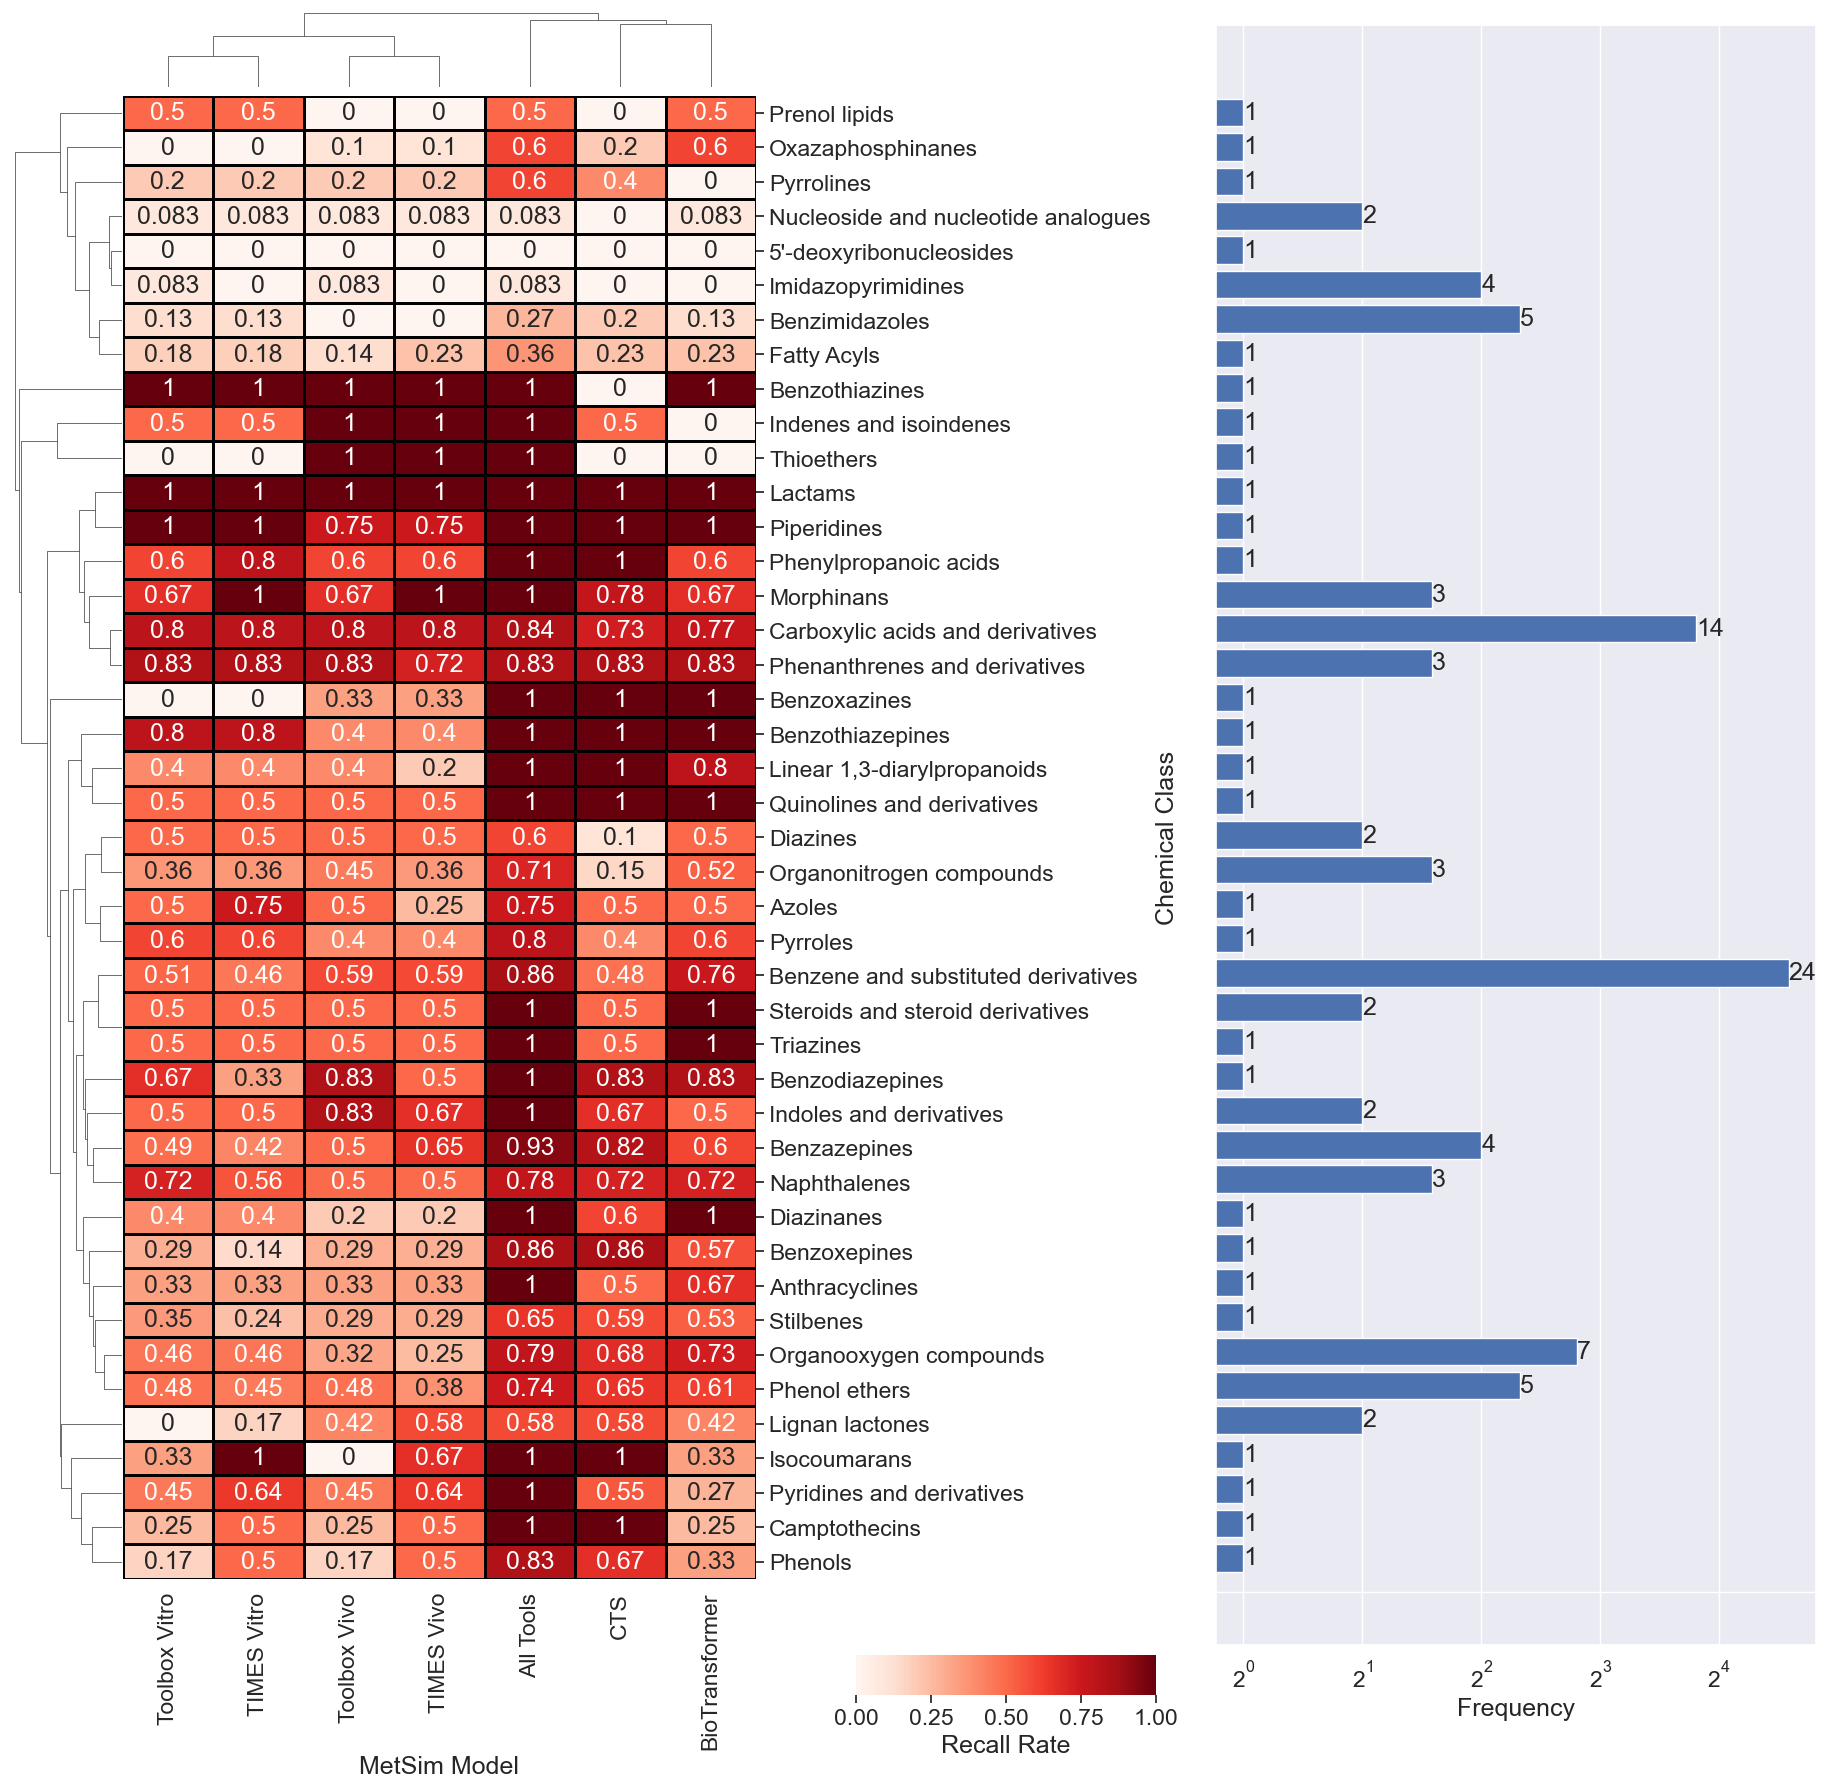

In [20]:
sns.set(font_scale=1.5)
drug_heatmap = sns.clustermap(tpr_df.loc[:,['chem_class','btrans_tpr','tb_s9_tpr','tb_vivo_tpr','times_s9_tpr','times_vivo_tpr','cts_tpr','aggregate_tpr']].groupby('chem_class').mean(),
                              linewidths=1, 
                              linecolor='black',
                              yticklabels=1,
                              cmap = 'Reds',
                              cbar_kws={'label': 'Recall Rate', 'orientation': 'horizontal'},
                              dendrogram_ratio=(0.15,0.05),
                              annot = True)
drug_heatmap.ax_heatmap.axes.set_xticklabels(['Toolbox Vitro', 'TIMES Vitro','Toolbox Vivo', 'TIMES Vivo', 'All Tools', 'CTS', 'BioTransformer'], rotation = 90)
drug_heatmap.ax_heatmap.set_ylabel('Chemical Class')
drug_heatmap.ax_heatmap.set_xlabel('MetSim Model')
drug_heatmap.fig.set_size_inches(20,20)
drug_heatmap.fig.subplots_adjust(right=0.4)
drug_heatmap.ax_cbar.set_position([0.45,0.13, 0.15,0.02])
# plt.savefig('C:\\Users\\LGROFF\\OneDrive - Environmental Protection Agency (EPA)\\Profile\\Documents\\Data\\GenRA\\BioTransformer3.0\\unilever_clustermap.png',facecolor='white',dpi=300)
sorted_yticks_drugs = drug_heatmap.ax_heatmap.axes.get_yticklabels()
sorted_yticks_drugs = [sorted_yticks_drugs[i].get_text() for i in range(len(sorted_yticks_drugs))]

clyf_unique = sorted_yticks_drugs
clyf_counts = [len([tpr_df.loc[i,'chem_class'] for i in tpr_df.index if tpr_df.loc[i,'chem_class'] == clyf_unique[j]]) for j in range(len(clyf_unique))]
bars = drug_heatmap.fig.add_axes([0.63, 0.155, 0.3, 0.81])
barlabs = bars.bar_label(bars.barh(clyf_unique, clyf_counts, color='C0'))
bars.invert_yaxis()
bars.set_xscale('log', base=2)
bars.set_xlabel('Frequency')
bars.set_yticks('')
plt.savefig(figures_dir+'Figure4.jpg',facecolor='white', dpi=300)

In [21]:
import openpyxl

In [22]:
louis_chk = pd.read_excel(processed_dir+'MetSim_Performance_Table_v2.xlsx')

In [23]:
louis_chk.shape

(112, 37)

In [24]:
#louis_chk.info()

In [25]:
tpr_df.columns

Index(['parent_name', 'parent_inchi', 'chem_class', 'n_metabolites',
       'cts_n_preds', 'cts_n_tp', 'cts_tpr', 'cts_n_fn', 'btrans_n_preds',
       'btrans_n_tp', 'btrans_tpr', 'btrans_n_fn', 'tb_s9_n_preds',
       'tb_s9_n_tp', 'tb_s9_tpr', 'tb_s9_n_fn', 'tb_vivo_n_preds',
       'tb_vivo_n_tp', 'tb_vivo_tpr', 'tb_vivo_n_fn', 'times_s9_n_preds',
       'times_s9_n_tp', 'times_s9_tpr', 'times_s9_n_fn', 'times_vivo_n_preds',
       'times_vivo_n_tp', 'times_vivo_tpr', 'times_vivo_n_fn',
       'aggregate_n_preds', 'aggregate_n_tp', 'aggregate_tpr',
       'aggregate_n_fn'],
      dtype='object')

In [26]:
assert (louis_chk['cts_n_tp'] == tpr_df['cts_n_tp']).all()

In [27]:
for col in tpr_df.columns:
    if col in louis_chk.columns:
        #a = tpr_df[col].equals(louis_chk[col]) 
        a = (tpr_df[col] == louis_chk[col]).all()
        if a == False:
            print(col)

cts_tpr
btrans_tpr
tb_s9_tpr
tb_vivo_tpr
times_s9_tpr
times_vivo_tpr
aggregate_tpr


In [29]:
#tpr_df[~tpr_df['cts_tpr'].isin(louis_chk['cts_tpr'])]

In [32]:
tpr_df.parent_name.nunique()

112

In [34]:
tool_dict2.keys()

dict_keys(['cts', 'btrans', 'tb_s9', 'tb_vivo', 'times_s9', 'times_vivo', 'aggregate'])

In [36]:
#tool_dict2['cts']

In [39]:
new_df = tpr_df.copy()

In [40]:
new_df.columns

Index(['parent_name', 'parent_inchi', 'chem_class', 'n_metabolites',
       'cts_n_preds', 'cts_n_tp', 'cts_tpr', 'cts_n_fn', 'btrans_n_preds',
       'btrans_n_tp', 'btrans_tpr', 'btrans_n_fn', 'tb_s9_n_preds',
       'tb_s9_n_tp', 'tb_s9_tpr', 'tb_s9_n_fn', 'tb_vivo_n_preds',
       'tb_vivo_n_tp', 'tb_vivo_tpr', 'tb_vivo_n_fn', 'times_s9_n_preds',
       'times_s9_n_tp', 'times_s9_tpr', 'times_s9_n_fn', 'times_vivo_n_preds',
       'times_vivo_n_tp', 'times_vivo_tpr', 'times_vivo_n_fn',
       'aggregate_n_preds', 'aggregate_n_tp', 'aggregate_tpr',
       'aggregate_n_fn'],
      dtype='object')

In [43]:
cts_df = new_df[['parent_name', 
       'cts_n_preds', 'cts_n_tp', 'cts_tpr', 'cts_n_fn']]

In [49]:
def calculate_tpr_fpr(row):
    TP = row['cts_n_tp']
    FN = row['cts_n_fn']
    N = row['cts_n_preds']

    # Calculate True Positive Rate (Sensitivity or Recall)
    TPR = TP / (TP + FN)

    # Calculate False Positive Rate
    FPR = 0  # Initialize FPR to 0 for this example
    if N - TP + FN > 0:
        FPR = FN / (N - TP + FN)

    return TPR, FPR

In [51]:
cts_df[['TPR', 'FPR']] = cts_df.apply(calculate_tpr_fpr, axis=1, result_type='expand')

/tmp/ipykernel_2233504/1830821734.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cts_df[['TPR', 'FPR']] = cts_df.apply(calculate_tpr_fpr, axis=1, result_type='expand')
/tmp/ipykernel_2233504/1830821734.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cts_df[['TPR', 'FPR']] = cts_df.apply(calculate_tpr_fpr, axis=1, result_type='expand')


In [52]:
cts_df

,parent_name,cts_n_preds,cts_n_tp,cts_tpr,cts_n_fn,TPR,FPR
0,Aripiprazole,229,5,1.000000,0,1.000000,0.000000
1,Atorvastatin,174,3,0.600000,2,0.600000,0.011561
2,Buprenorphine,146,1,1.000000,0,1.000000,0.000000
3,Celecoxib,23,2,0.500000,2,0.500000,0.086957
4,Clopidogrel,185,3,0.750000,1,0.750000,0.005464
...,...,...,...,...,...,...,...
107,Tenofovir,19,0,0.000000,2,0.000000,0.095238
108,Thioguanine,9,0,0.000000,1,0.000000,0.100000
109,Tramadol,143,5,0.833333,1,0.833333,0.007194
110,Trandolapril,300,1,1.000000,0,1.000000,0.000000


Text(0.5, 1.0, 'ROC Curve for CTS')

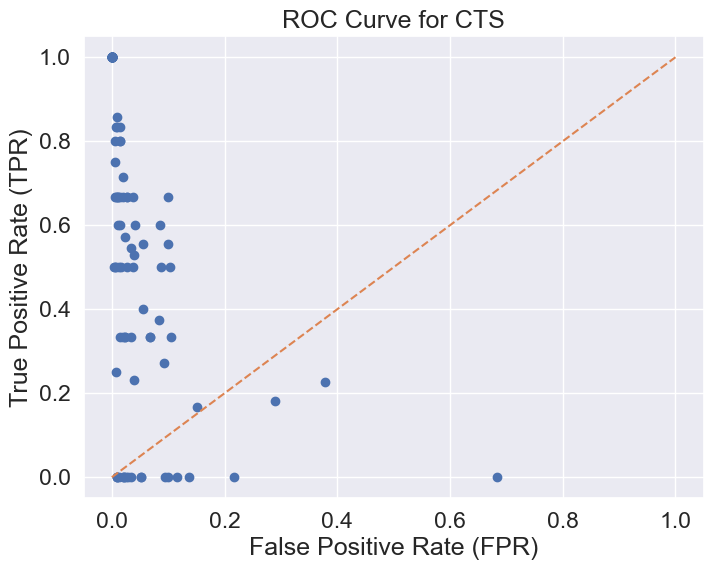

In [55]:
plt.figure(figsize=(8, 6))
plt.plot(cts_df['FPR'], cts_df['TPR'], marker='o', linestyle = 'None',label='Point on ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for CTS')

In [57]:
cts_df.sum()

parent_name    AripiprazoleAtorvastatinBuprenorphineCelecoxib...
cts_n_preds                                                13464
cts_n_tp                                                     234
cts_tpr                                                68.983089
cts_n_fn                                                     198
TPR                                                    68.983089
FPR                                                     4.174063
dtype: object

In [3]:
performance = {'TP':[234,216,173,173,172,170,313], 'FP':[13230,27296,1289,1030,1120,1162,38303], 'FN':[198,216,259,259,260,262,119], 'N':[13464, 27512,1462,1203,1292,1332,38616], 'Tool':['CTS', 'BioTransformer', 'TB_iv', 'TB_ivt', 'TIMES_iv', 'TIMES_ivt', 'Ensemble']}

In [4]:
performance_df = pd.DataFrame(performance)

In [5]:
performance_df

,TP,FP,FN,N,Tool
0,234,13230,198,13464,CTS
1,216,27296,216,27512,BioTransformer
2,173,1289,259,1462,TB_iv
3,173,1030,259,1203,TB_ivt
4,172,1120,260,1292,TIMES_iv
5,170,1162,262,1332,TIMES_ivt
6,313,38303,119,38616,Ensemble


In [6]:
def calculate_tpr_fpr(row):
    TP = row['TP']
    FN = row['FN']
    N = row['N']

    # Calculate True Positive Rate (Sensitivity or Recall)
    TPR = TP / (TP + FN)

    # Calculate False Positive Rate
    FPR = 0  # Initialize FPR to 0 for this example
    if N - TP + FN > 0:
        FPR = FN / (N - TP + FN)

    return TPR, FPR

In [7]:
performance_df[['TPR', 'FPR']] = performance_df.apply(calculate_tpr_fpr, axis=1, result_type='expand')

In [8]:
performance_df

,TP,FP,FN,N,Tool,TPR,FPR
0,234,13230,198,13464,CTS,0.541667,0.014745
1,216,27296,216,27512,BioTransformer,0.500000,0.007851
2,173,1289,259,1462,TB_iv,0.400463,0.167313
3,173,1030,259,1203,TB_ivt,0.400463,0.200931
4,172,1120,260,1292,TIMES_iv,0.398148,0.188406
5,170,1162,262,1332,TIMES_ivt,0.393519,0.183989
6,313,38303,119,38616,Ensemble,0.724537,0.003097


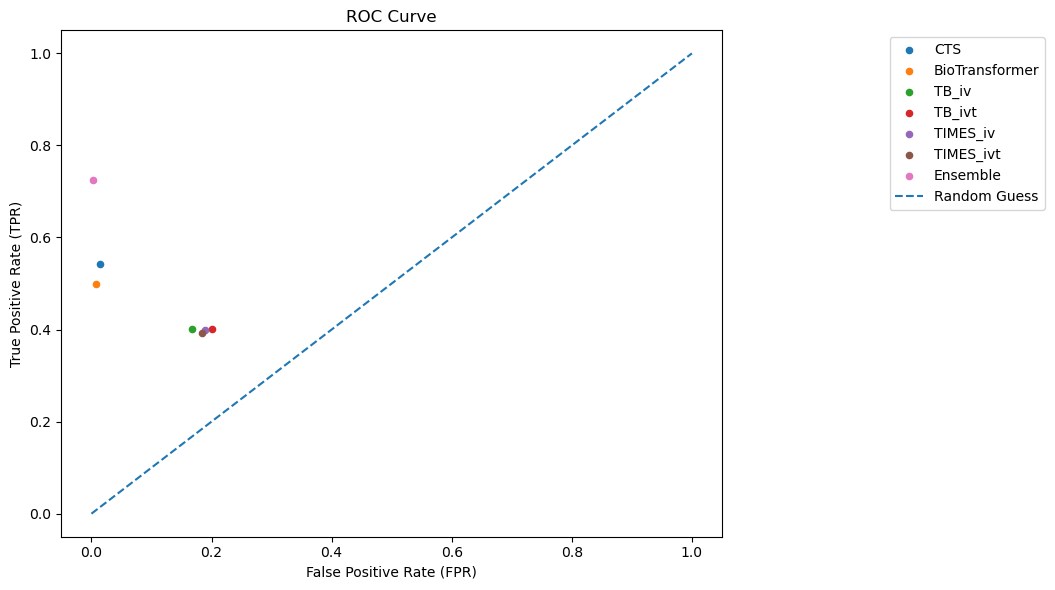

In [9]:
plt.figure(figsize=(12, 6))
for i, row in performance_df.iterrows():
    plt.scatter(row['FPR'], row['TPR'],  label=row['Tool'], s=20)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0))
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.tight_layout()
plt.savefig(figures_dir+'Roc.tiff', format='tiff', dpi=300 )